# Analyzing Neural Time Series Data: Chapter 11

#### Converted from MATLAB to Python by Andrew J. Graves on 01/08/20

In [1]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from mpl_toolkits.mplot3d import Axes3D # For 3d visualization
plt.rc('font', size=8)

# Run data extraction and useful function script; double quotes work for Windows and Mac paths
%run "data_and_funcs.ipynb"

### Figure 11.1

<IPython.core.display.Javascript object>


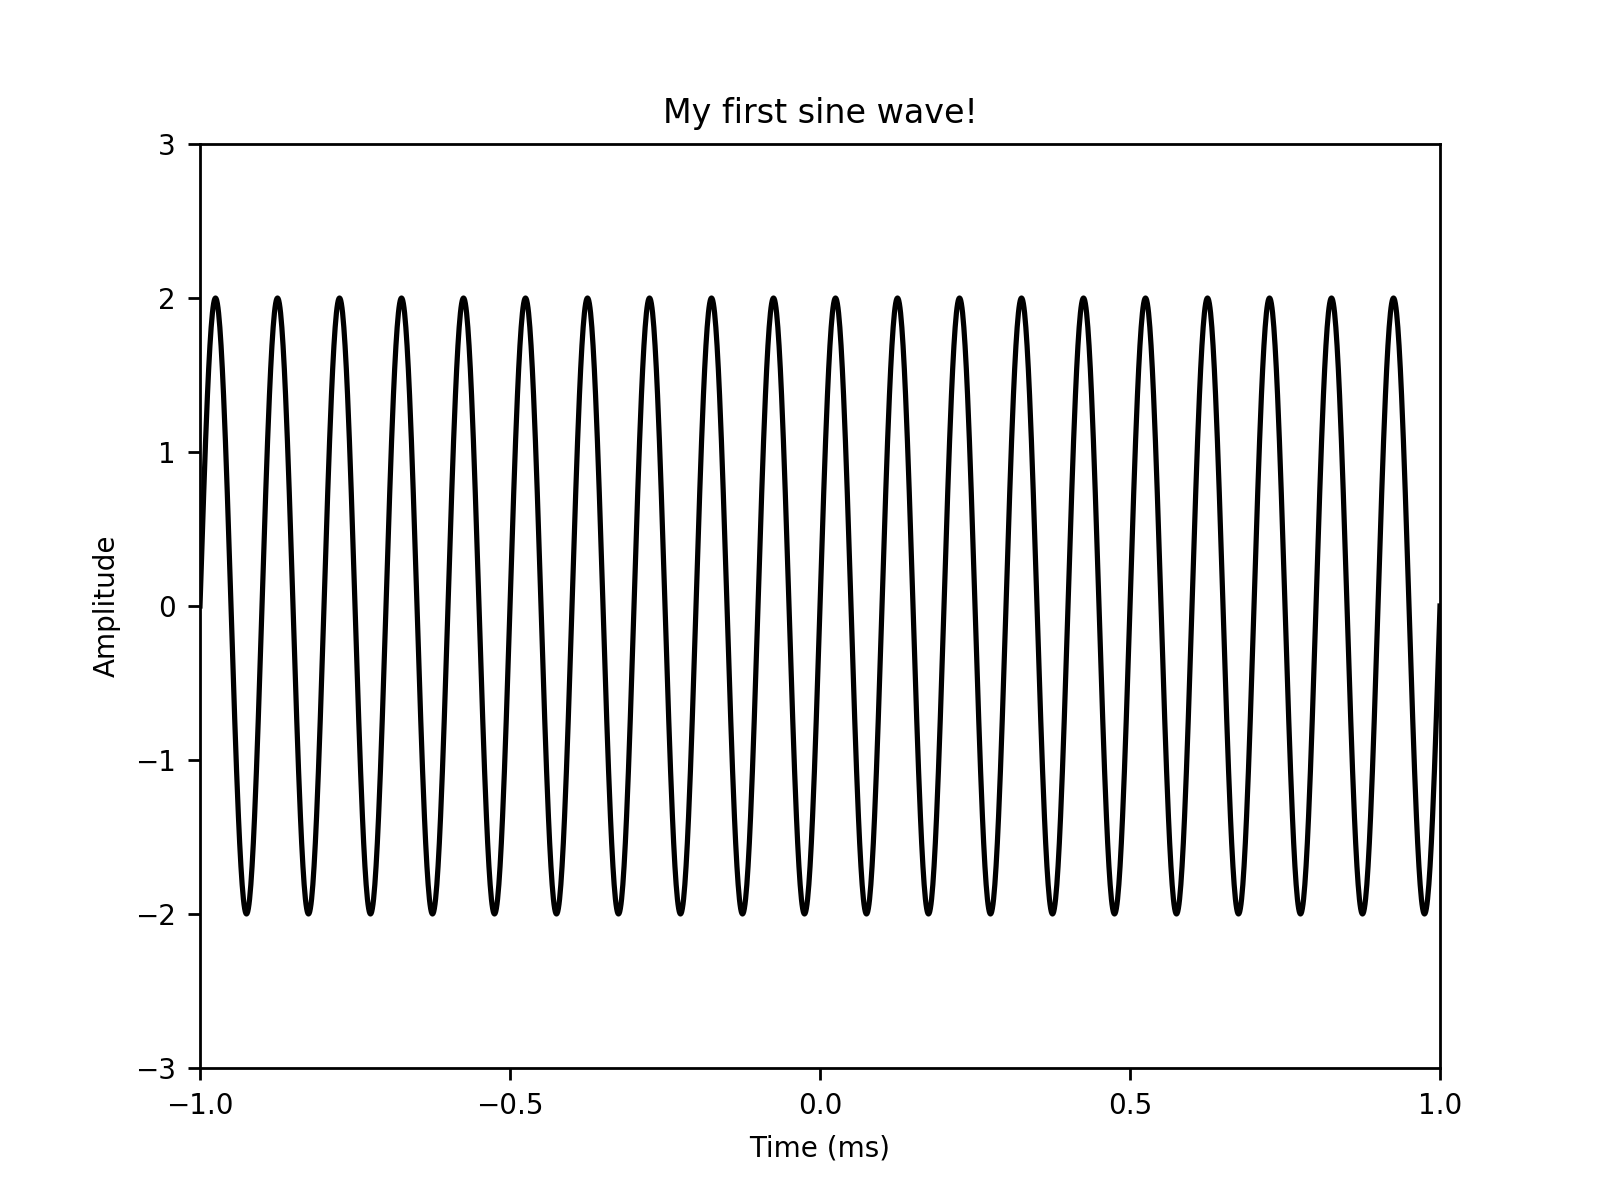

In [2]:
# Get matplotlib magick
%matplotlib notebook

srate = 1000 # sampling rate in Hz
time = np.arange(-1, 1 + 1/srate, 1/srate)
freq = 10 # in Hz
amp = 2 # amplitude or height of the sine wave

def get_sine_wave(frequency, amplitude, time_vec, phase=0):
    return amplitude * np.sin(2 * np.pi * frequency * time_vec + phase)

sine_wave = get_sine_wave(freq, amp, time)

plt.plot(time, sine_wave, color='black')
plt.xlim([-1, 1])
plt.ylim([-3, 3])
plt.xticks(np.arange(-1, 1.5, .5))
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('My first sine wave!')
plt.show()

### Figure 11.2

<IPython.core.display.Javascript object>


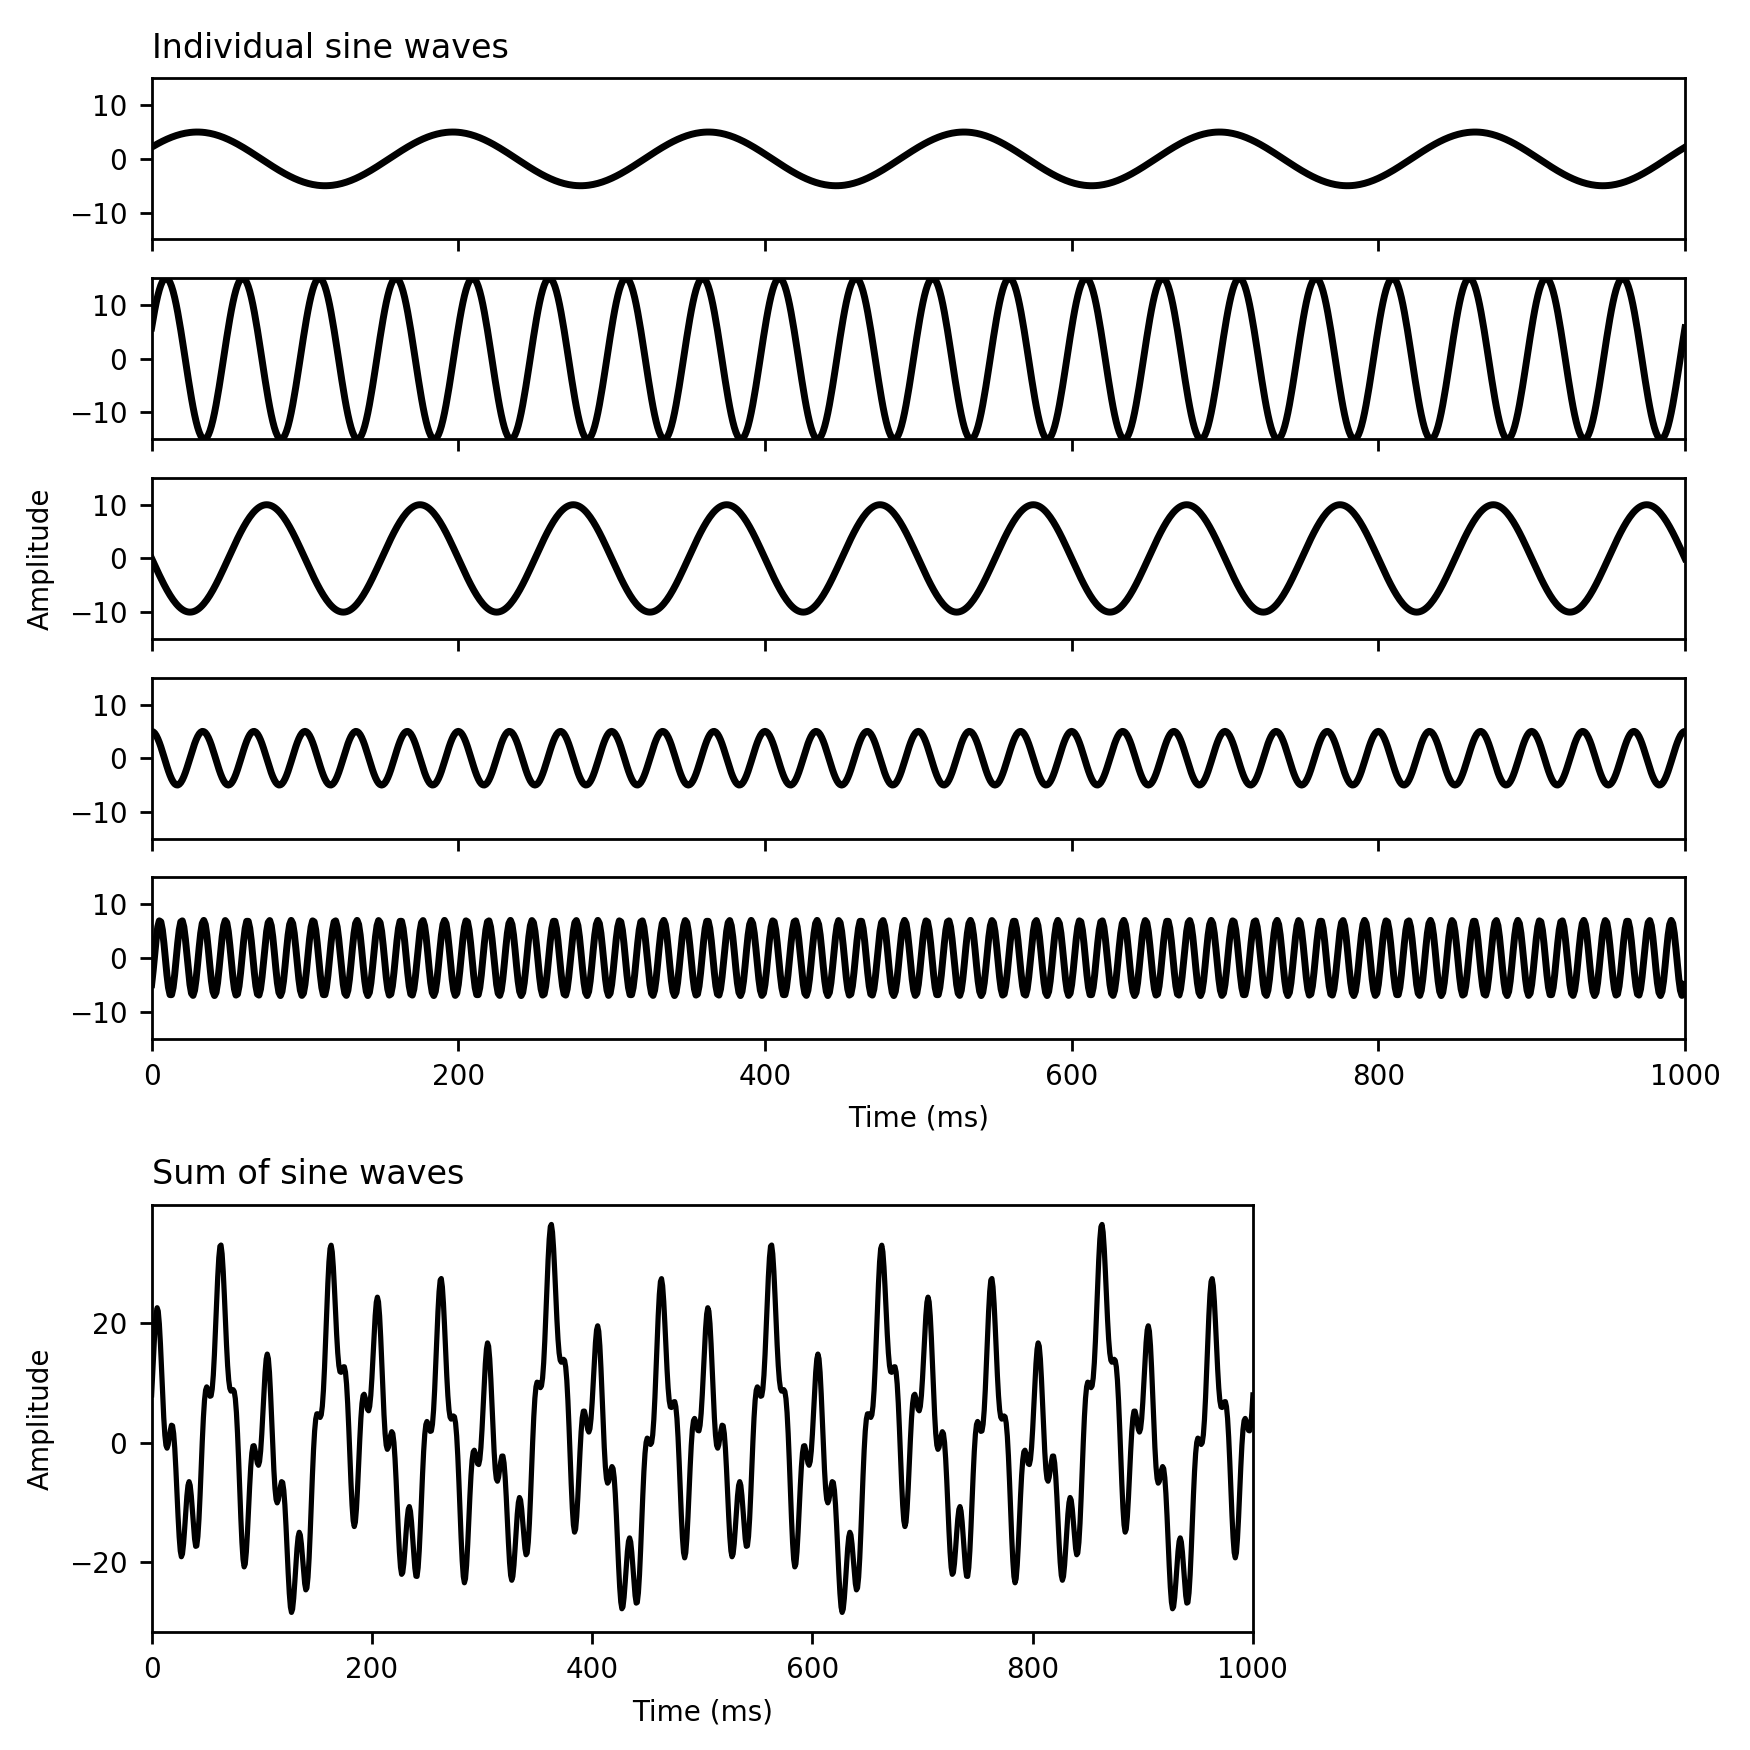

In [3]:
srate = 500
time = np.arange(-1, 1 + 1/srate, 1/srate)

# Arbitrary frequencies
freqs = np.array([3, 10, 5, 15, 35])

# Arbitrary amplitudes (same len as freqs)
amps = np.array([5, 15, 10, 5, 7])

# Arbitrary phases between -pi and pi
phases = np.array([np.pi / 7, np.pi / 8, np.pi, np.pi / 2, -np.pi / 4])

# Initialize sine waves array
sine_waves = np.zeros((len(freqs), len(time)))

# Iterate through parameters to generate different sinewaves
for i in np.arange(len(freqs)):
    sine_waves[i, :] = get_sine_wave(freqs[i], amps[i], time, phases[i])

# Figure 11.2 ----------

# Set the figure and grid
fig_112 = plt.figure(figsize=(7, 7))
full_grid = fig_112.add_gridspec(2, 2, height_ratios=[2.25, 1], width_ratios=[3, 1])

# Set the subgrids
grid_A = full_grid[0, :].subgridspec(len(freqs), 1)
grid_B = full_grid[1, 0].subgridspec(1, 1)

# Add a sinewave to each row in grid A
for i in range(len(freqs)):
    ax_A = fig_112.add_subplot(grid_A[i, 0])
    ax_A.plot(sine_waves[i, :], linewidth=2, color='black')
    ax_A.set_xlim([0, 1000])
    ax_A.set_ylim([-np.max(amps), np.max(amps)])
    
    # Format appropriately (A pain, but as AFAICT no sharex attribute with subplot grids)
    if i == 0:
        ax_A.set_title('Individual sine waves', loc='left')
    if i == 2:
        ax_A.set_ylabel('Amplitude')
    if i == len(freqs) - 1:
        ax_A.set_xlabel('Time (ms)')
    else:
        ax_A.set_xticklabels([])

# Sum all the sine waves and plot below
ax_B = fig_112.add_subplot(grid_B[0, 0])
ax_B.plot(np.sum(sine_waves, axis=0), color='black')
ax_B.set_xlim([0, 1000])
ax_B.set_xlabel('Time (ms)')
ax_B.set_ylabel('Amplitude')
ax_B.set_title('Sum of sine waves', loc='left')
fig_112.tight_layout()

### Figure 11.3

<IPython.core.display.Javascript object>


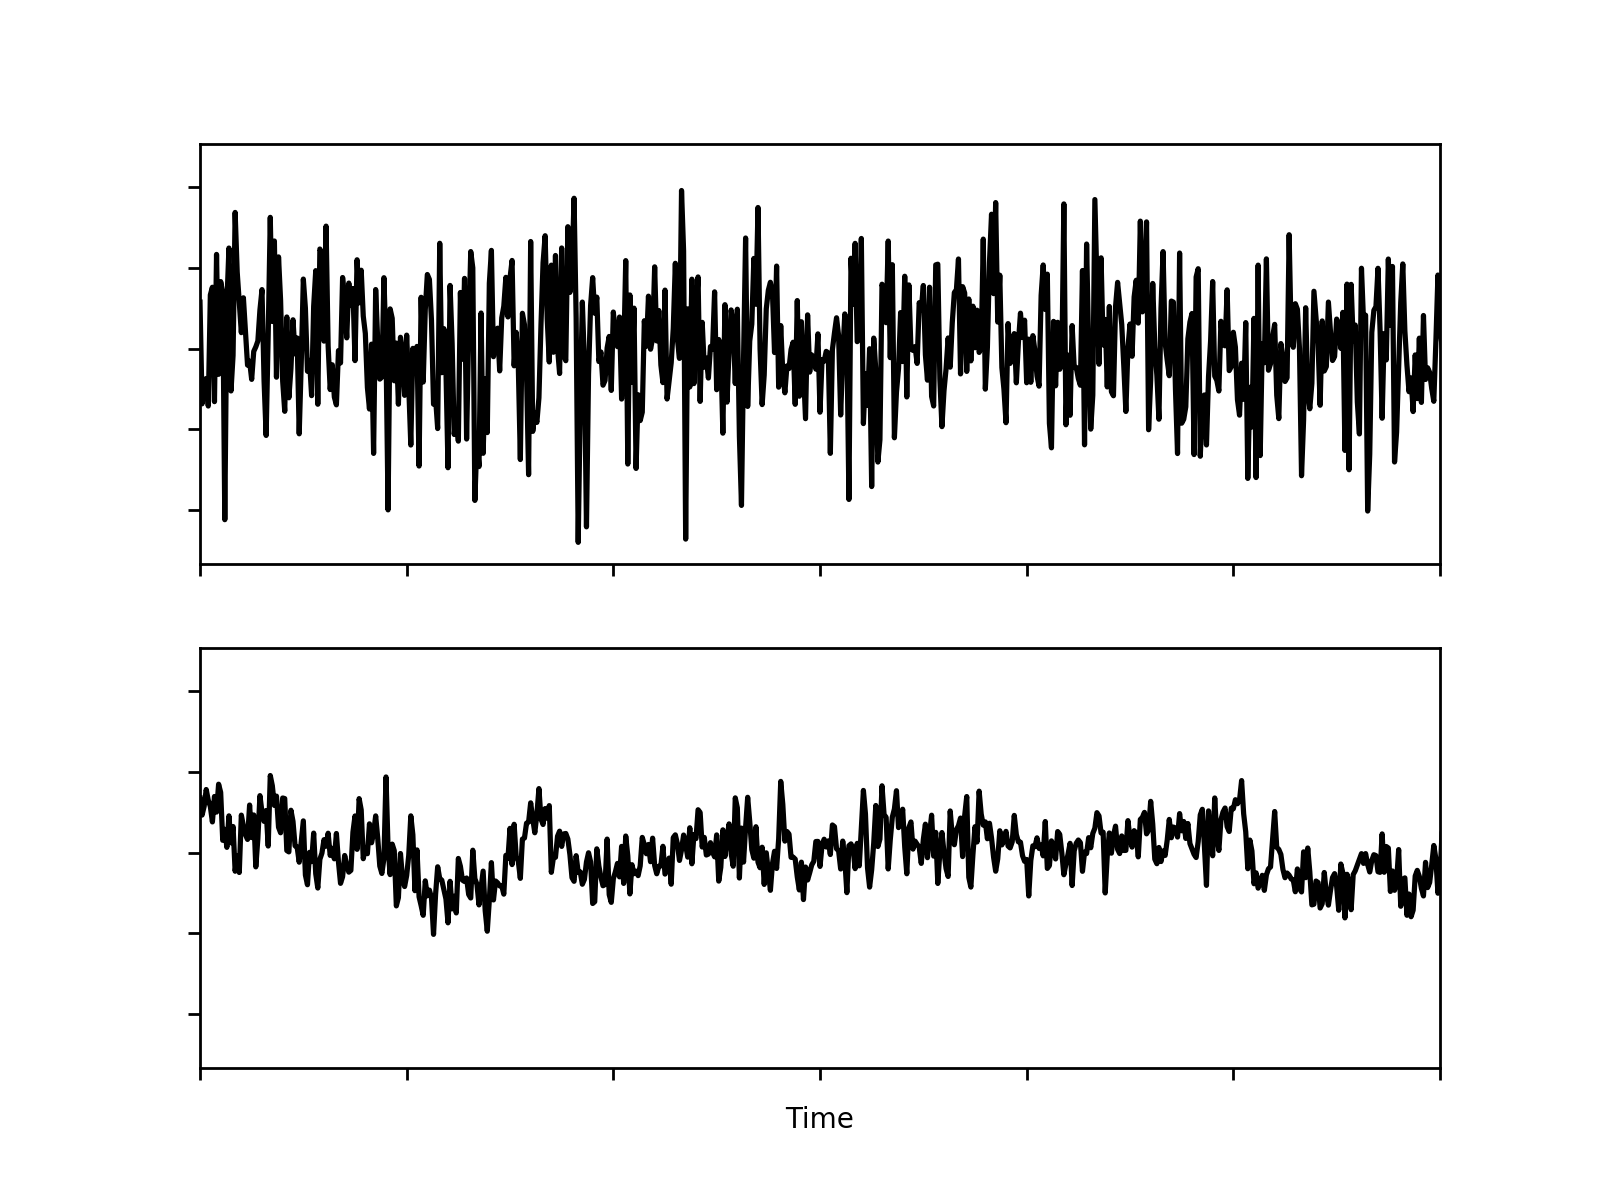

In [4]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True)

# Sine-waves plus random noise; top panel
ax[0].plot(np.sum(sine_waves * np.random.normal(size=sine_waves.shape), axis=0), color='black')
# EEG data at index 1 channel, index 1 trial; bottom panel
ax[1].plot(eeg_data[1, :, 1], color='black')

plt.xlim([0, 600])
plt.xlabel('Time')
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
plt.show()

### Figure 11.4

<IPython.core.display.Javascript object>


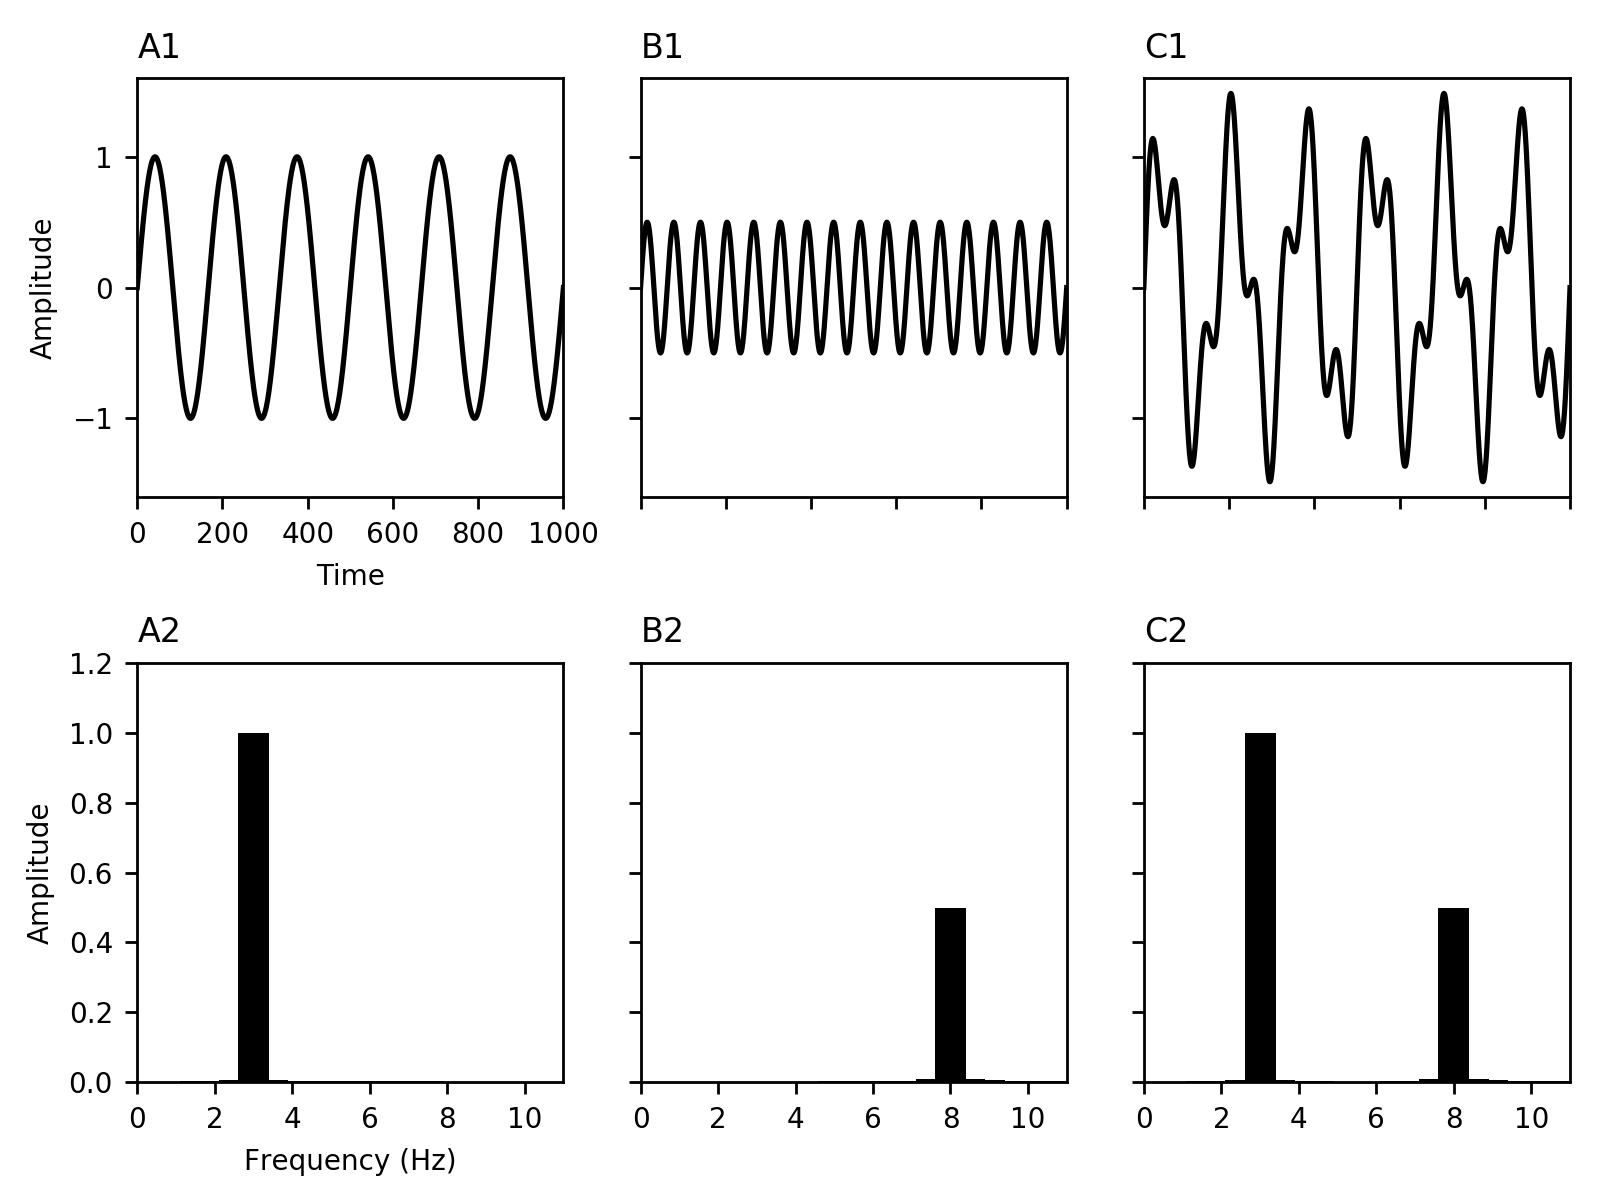

In [5]:
sine_1 = get_sine_wave(frequency=3, amplitude=1, time_vec=time)
sine_2 = get_sine_wave(frequency=8, amplitude=0.5, time_vec=time)
sine_3 = sine_1 + sine_2

# To get letters from numbers for labelling
def pos_to_char(pos):
    return chr(pos + 97).upper()

fig, ax = plt.subplots(nrows=2, ncols=3)
for i in range(3):
    # Sine waves
    sines = 'sine_' + str(i + 1)
    ax[0, i].plot(eval(sines), color='black')
    ax[0, i].set_xlim([0, 1000])
    ax[0, i].set_ylim([-1.6, 1.6])
    ax[0, i].set_yticks([-1, 0, 1])
    ax[0, i].set_title(pos_to_char(i) + str(1), loc='left')
    
    # Discrete fourier transforms
    f = np.fft.fft(eval(sines)) / len(time)
    hz = np.linspace(0, srate/2, int(np.floor(len(time) / 2) + 1))
    ax[1, i].bar(hz, height=np.abs(f[0:len(hz)] * 2), color='black')
    ax[1, i].set_xticks(np.arange(0, 11, 2))
    ax[1, i].set_xlim([0, 11])
    ax[1, i].set_ylim([0, 1.2])
    ax[1, i].set_title(pos_to_char(i) + str(2), loc='left')
    
    # Formatting axes and labels
    if i != 0:
        ax[0, i].set_xticklabels([])
        ax[0, i].set_yticklabels([])
        ax[1, i].set_yticklabels([])
    else:
        ax[0, i].set_xlabel('Time')
        ax[0, i].set_ylabel('Amplitude')
        ax[1, i].set_xlabel('Frequency (Hz)')
        ax[1, i].set_ylabel('Amplitude')

plt.tight_layout()

### Figure 11.5

In [6]:
n = 10 #length of sequence
srate = 200 #sampling rate in Hz
data = np.random.normal(size=n) #random numbers
nyq = srate / 2 #Nyquist frequency, the highest measureable frequency in the data

# Initialize Fourier output matrix
fourier_unscaled = np.zeros(data.shape, dtype=complex)

# These are the actual frequencies in Hz that will be returned by the Fourier transform. The number of unique 
# frequencies we can measure is exactly 1/2 of the number of data points in the time series (plus DC).
freqs = np.linspace(0, nyq, int(n / 2 + 1))
time = (np.arange(1, n + 1) - 1) / n

# The Fourier transform is the dot product between the sine wave and data at each frequency
for i in range(n):
    sine_wave = np.exp(-1j * 2 * np.pi * i * time)
    fourier_unscaled[i] = np.dot(sine_wave, data)

<IPython.core.display.Javascript object>


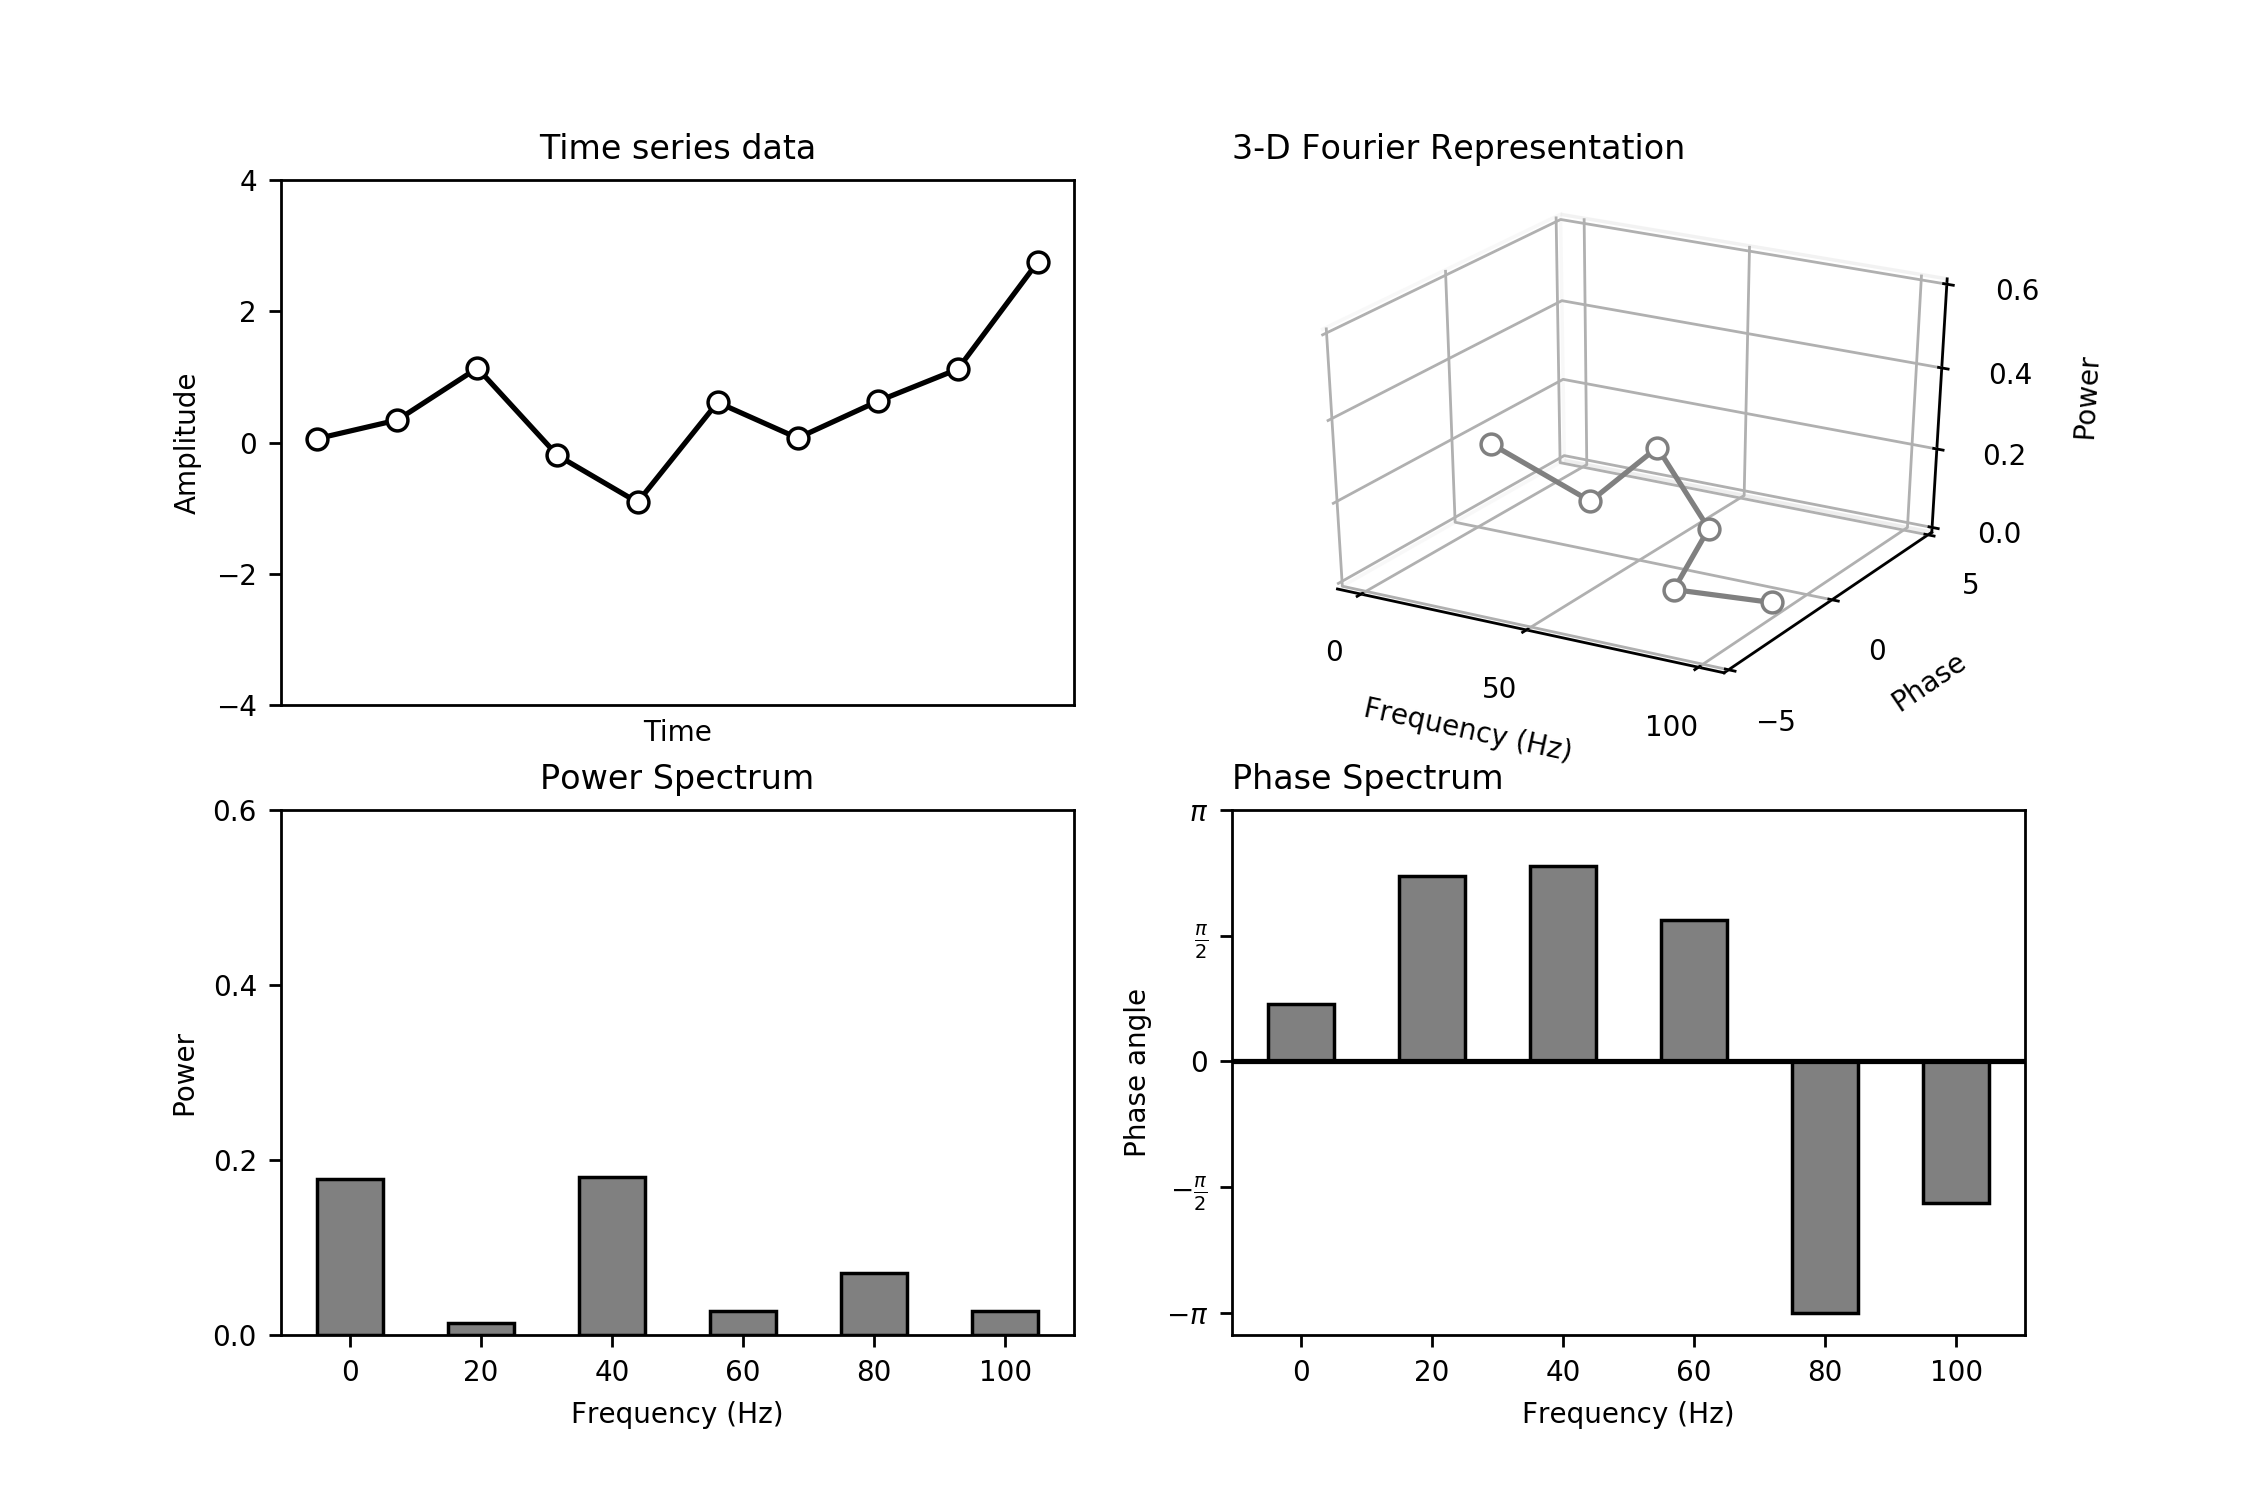

In [7]:
fourier = fourier_unscaled / n
ft_idx = np.arange(0, int(n / 2) + 1) + 1
ft_power = np.power(np.abs(fourier[ft_idx]), 2)
ft_phase = np.angle(fourier[ft_idx], deg=False)

# Figure 11.5 ----------

fig = plt.figure(figsize=(9, 6))

# Time series
ax_1 = plt.subplot(2, 2, 1)
ax_1.plot(data, color='black', marker='o', markerfacecolor='white')
ax_1.set_xticks([])
ax_1.set_yticks(np.arange(-4, 5, 2))
ax_1.set_ylim([-4, 4])
ax_1.set_xlabel('Time')
ax_1.set_ylabel('Amplitude')
ax_1.set_title('Time series data')

ax_2 = plt.subplot(2, 2, 2, projection='3d')
ax_2.plot3D(freqs, ft_phase, ft_power, zdir = 'z', color='gray', marker='o', markerfacecolor='white')
ax_2.set_xticks(np.linspace(0, 100, 3))
ax_2.set_yticks(np.linspace(-5, 5, 3))
ax_2.set_zticks(np.linspace(0, .6, 4))
ax_2.set_xlabel('Frequency (Hz)')
ax_2.set_ylabel('Phase')
ax_2.set_zlabel('Power')
ax_2.set_title('3-D Fourier Representation', loc='left')
ax_2.xaxis.pane.fill = False
ax_2.yaxis.pane.fill = False
ax_2.zaxis.pane.fill = False

ax_3 = plt.subplot(2, 2, 3)
ax_3.bar(freqs, height=ft_power, width=10, color='grey', edgecolor='black')
ax_3.set_xticks(np.linspace(0, 100, 6))
ax_3.set_yticks(np.linspace(0, .6, 4))
ax_3.set_xlabel('Frequency (Hz)')
ax_3.set_ylabel('Power')
ax_3.set_title('Power Spectrum')

ax_4 = plt.subplot(2, 2, 4)
ax_4.bar(freqs, height=ft_phase, width=10, color='grey', edgecolor='black')
ax_4.axhline(color='black')
ax_4.set_yticks(np.arange(-np.pi, np.pi + 1, np.pi / 2))
ax_4.set_yticklabels((r'$-\pi$', r'$-\frac{\pi}{2}$', '0', r'$\frac{\pi}{2}$', r'$\pi$'))
ax_4.set_xlabel('Frequency (Hz)')
ax_4.set_ylabel('Phase angle')
ax_4.set_title('Phase Spectrum', loc='left')

plt.show()

### Figure 11.6

<IPython.core.display.Javascript object>


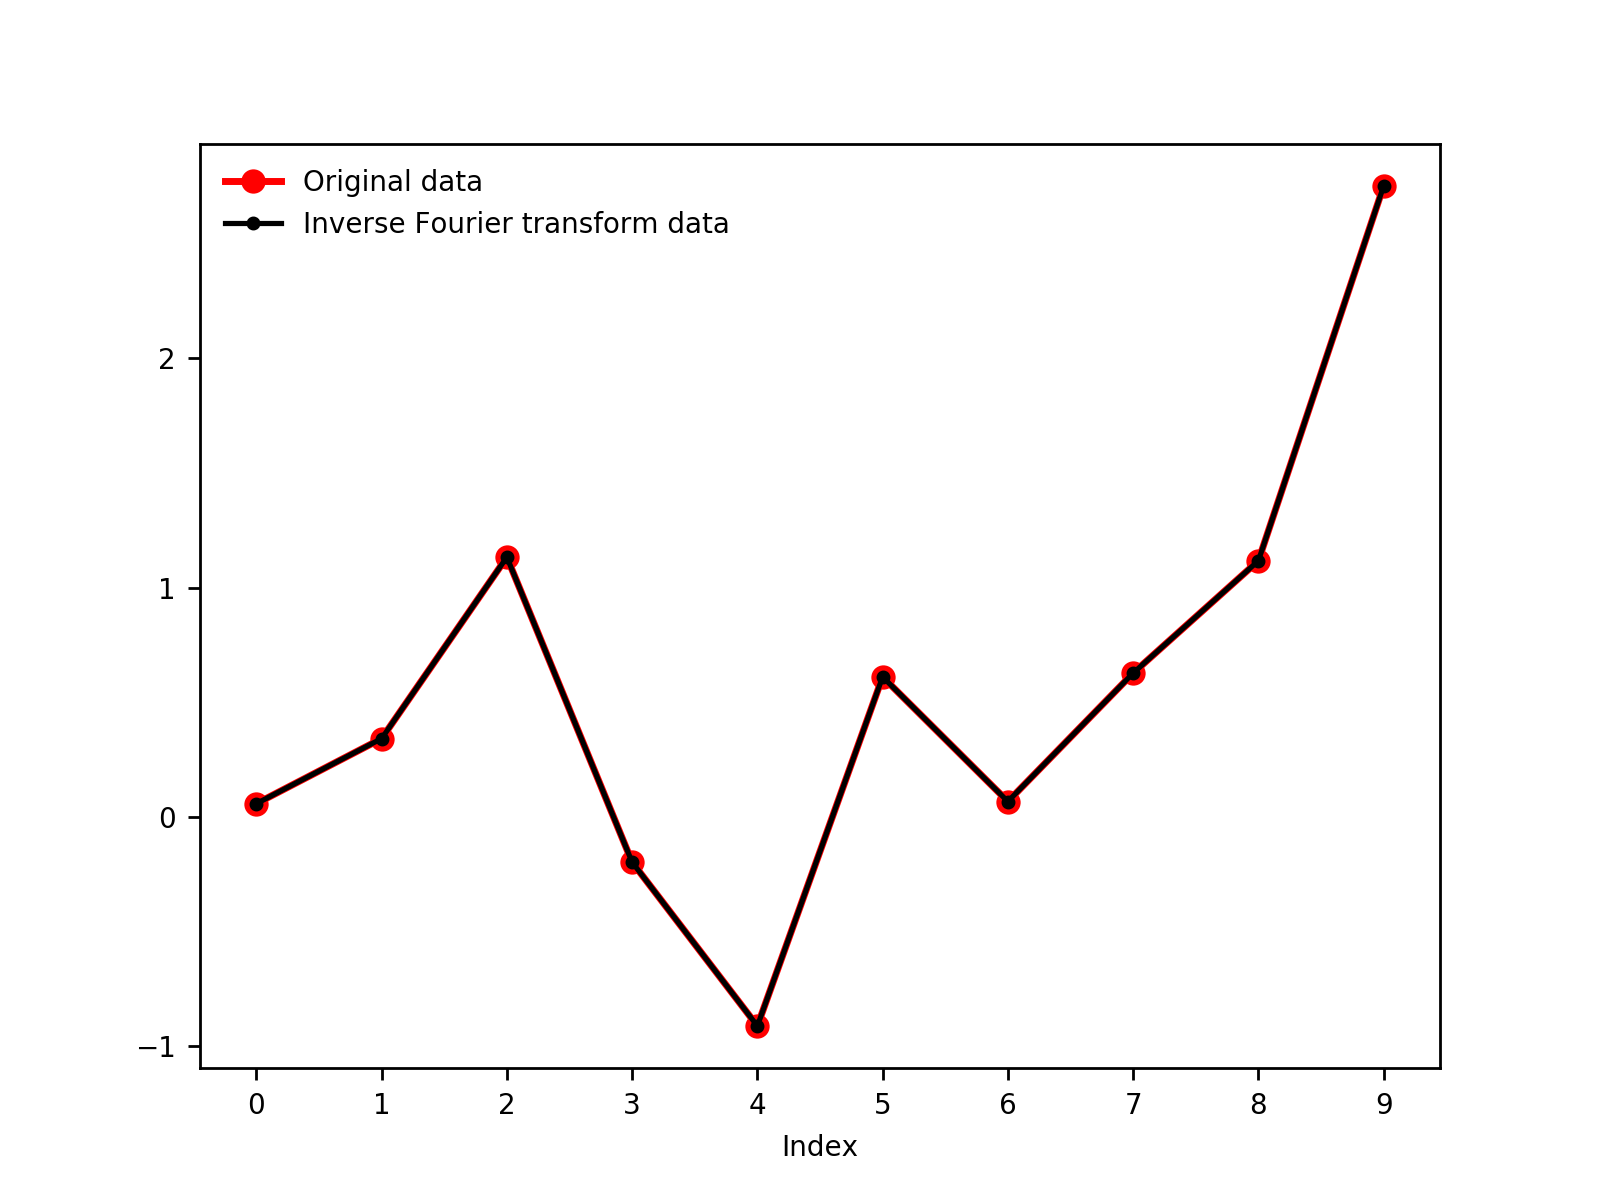

In [8]:
# Compute sine waves and sum to recover the original time series
reconstruct_data = np.zeros(data.shape)

for i in range(n):
    # Scale sine wave by Fourier coefficient
    sine_wave = fourier[i] * np.exp(1j * 2 * np.pi * i * time)
    # Sum sine waves together (take only real part)
    reconstruct_data = reconstruct_data + np.real(sine_wave)

plt.figure()
plt.plot(data, color='red', marker='o', linewidth=2)
plt.plot(reconstruct_data, color='black', marker='.')
plt.yticks(np.linspace(-1, 2, 4))
plt.xticks(np.arange(0, 10))
plt.xlabel('Index')
plt.legend(labels=('Original data', 'Inverse Fourier transform data'), frameon=False)
plt.show()